In [1]:
import os
import numpy as np
import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.models import Model
# from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2

2023-10-21 15:42:47.439009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-21 15:42:47.546327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-21 15:42:47.546344: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-21 15:42:47.569600: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-21 15:42:48.017056: W tensorflow/stream_executor/pla

In [3]:
import pandas as pd
df = pd.read_csv('./datasets/datathon_train.csv')

In [7]:
df.info

<bound method DataFrame.info of             Id  MONTH  DAY_OF_MONTH  DAY_OF_WEEK  \
0            0      1            17            4   
1            1      2            27            3   
2            2      8            14            3   
3            3      3            16            6   
4            4      6            20            4   
...        ...    ...           ...          ...   
697219  697219      4             4            4   
697220  697220     10            22            2   
697221  697221     10            30            3   
697222  697222     11            27            3   
697223  697223      8            12            1   

                   DEPARTING_AIRPORT       ORIGIN_CITY_NAME DEST  \
0       Raleigh-Durham International     Raleigh/Durham, NC  JFK   
1             San Jose International           San Jose, CA  BOS   
2          Los Angeles International        Los Angeles, CA  ATL   
3       Newark Liberty International             Newark, NJ  DTW   
4  

In [8]:
print(df.head())

   Id  MONTH  DAY_OF_MONTH  DAY_OF_WEEK             DEPARTING_AIRPORT  \
0   0      1            17            4  Raleigh-Durham International   
1   1      2            27            3        San Jose International   
2   2      8            14            3     Los Angeles International   
3   3      3            16            6  Newark Liberty International   
4   4      6            20            4             Douglas Municipal   

     ORIGIN_CITY_NAME DEST DEST_CITY_NAME DEP_TIME_BLK  DISTANCE  ...  \
0  Raleigh/Durham, NC  JFK   New York, NY    1800-1859       427  ...   
1        San Jose, CA  BOS     Boston, MA    2200-2259      2689  ...   
2     Los Angeles, CA  ATL    Atlanta, GA    0600-0659      1947  ...   
3          Newark, NJ  DTW    Detroit, MI    1400-1459       488  ...   
4       Charlotte, NC  JFK   New York, NY    1500-1559       541  ...   

   GROUND_SERV_PER_PASS  PLANE_AGE                   PREVIOUS_AIRPORT  PRCP  \
0              0.000094          5  Ronald 

In [9]:
#Count data imbalance
value_counts = df['IS_DELAYED'].value_counts()
print(value_counts)


IS_DELAYED
0    419013
1    278211
Name: count, dtype: int64


In [10]:
df.PREVIOUS_AIRPORT.unique()

array(['Ronald Reagan Washington National',
       'John F. Kennedy International', 'NONE',
       'Dallas Fort Worth Regional', 'Myrtle Beach International',
       'Quad City International', 'Jacksonville International',
       "Chicago O'Hare International", 'LaGuardia',
       'Houston Intercontinental', 'Wilkes Barre Scranton International',
       'Atlanta Municipal', 'Seattle International',
       'Orlando International', 'Joe Foss Field',
       'Southwest Florida International', 'McCarran International',
       'Louis Armstrong New Orleans International',
       'San Jose International', 'Memphis International',
       'Newark Liberty International', 'Miami International',
       'Los Angeles International', 'Boise Air Terminal',
       'Honolulu International', 'Sacramento International',
       'Port Columbus International', 'Indianapolis Muni/Weir Cook',
       'Salt Lake City International', 'Palm Springs International',
       'San Francisco International', 'Phoenix Sky 

In [11]:
df.DEPARTING_AIRPORT.unique()

array(['Raleigh-Durham International', 'San Jose International',
       'Los Angeles International', 'Newark Liberty International',
       'Douglas Municipal', 'General Mitchell Field',
       "Chicago O'Hare International", 'John F. Kennedy International',
       'Cincinnati/Northern Kentucky International', 'Eppley Airfield',
       'Tucson International', 'Port Columbus International',
       'Atlanta Municipal', 'Orlando International',
       'Phoenix Sky Harbor International',
       'Cleveland-Hopkins International', 'Stapleton International',
       'Friendship International', 'Dallas Fort Worth Regional',
       'LaGuardia', 'Philadelphia International',
       'Metropolitan Oakland International', 'Charleston International',
       'Ronald Reagan Washington National', 'Detroit Metro Wayne County',
       'Standiford Field', 'James M Cox/Dayton International',
       'Austin - Bergstrom International', 'Nashville International',
       'San Francisco International', 'Houston 

In [13]:
df_ORIGIN = df.ORIGIN_CITY_NAME.unique()
df_DEST = df.DEST_CITY_NAME.unique()

df_ORIGIN = df_ORIGIN.tolist()
df_DEST = df_DEST.tolist()

In [18]:
df_DEPARTING = df.DEPARTING_AIRPORT.unique()
df_PREVIOUS = df.PREVIOUS_AIRPORT.unique()

df_DEPARTING = df_DEPARTING.tolist()
df_PREVIOUS = df_PREVIOUS.tolist()

print(df_DEPARTING)
print(df_PREVIOUS)

['Raleigh-Durham International', 'San Jose International', 'Los Angeles International', 'Newark Liberty International', 'Douglas Municipal', 'General Mitchell Field', "Chicago O'Hare International", 'John F. Kennedy International', 'Cincinnati/Northern Kentucky International', 'Eppley Airfield', 'Tucson International', 'Port Columbus International', 'Atlanta Municipal', 'Orlando International', 'Phoenix Sky Harbor International', 'Cleveland-Hopkins International', 'Stapleton International', 'Friendship International', 'Dallas Fort Worth Regional', 'LaGuardia', 'Philadelphia International', 'Metropolitan Oakland International', 'Charleston International', 'Ronald Reagan Washington National', 'Detroit Metro Wayne County', 'Standiford Field', 'James M Cox/Dayton International', 'Austin - Bergstrom International', 'Nashville International', 'San Francisco International', 'Houston Intercontinental', 'San Diego International Lindbergh Fl', 'Lihue Airport', 'Ontario International', 'Tampa Int

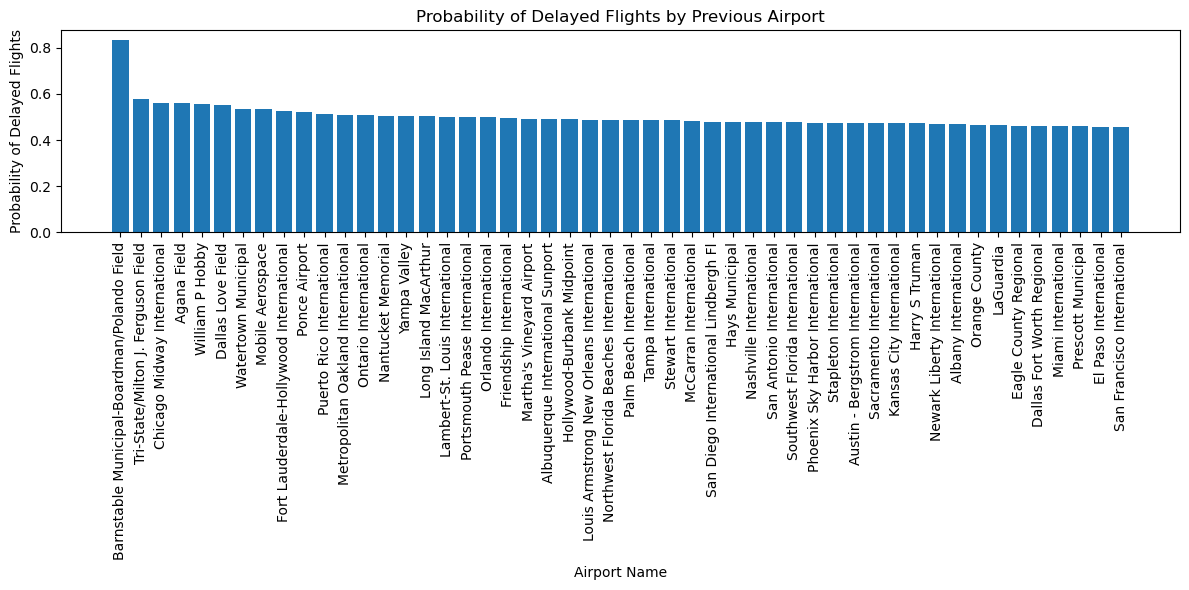

In [25]:
import matplotlib.pyplot as plt

delayed_flights = df[df['IS_DELAYED'] == 1]

# Group the data by "PREVIOUS_AIRPORT" and count the number of total flights for each airport
total_flights = df['PREVIOUS_AIRPORT'].value_counts()

# Group the delayed flights by "PREVIOUS_AIRPORT" and count the number of delayed flights for each airport
delayed_airports = delayed_flights['PREVIOUS_AIRPORT'].value_counts()

# Calculate the probability of delayed flights for each airport
probability_delayed = delayed_airports / total_flights

# Select the top 20 most popular airports
##top_20_airports = probability_delayed.head(30)
top_20_airports = probability_delayed.nlargest(50)


# Create a bar chart to visualize the probability of delayed flights for the top 20 airports
plt.figure(figsize=(12, 6))
plt.bar(top_20_airports.index, top_20_airports.values)
plt.xlabel("Airport Name")
plt.ylabel("Probability of Delayed Flights")
plt.title("Probability of Delayed Flights by Previous Airport")
plt.xticks(rotation=90)  # Rotate the x-axis labels for readability
plt.tight_layout()

# Display the bar chart
plt.show()

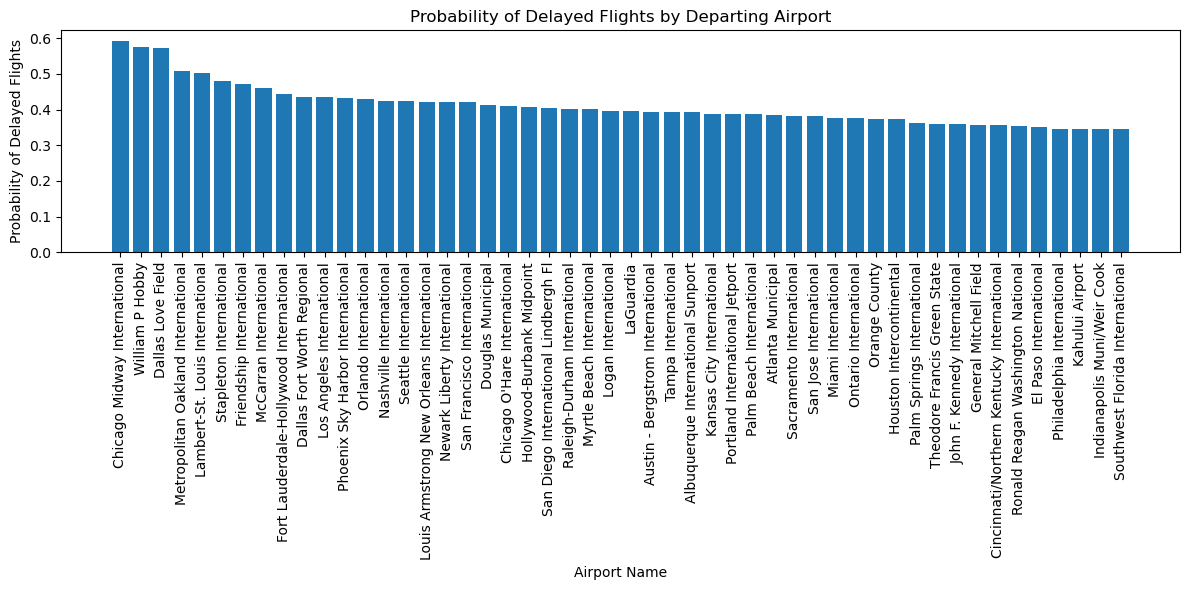

In [24]:
import matplotlib.pyplot as plt

delayed_flights = df[df['IS_DELAYED'] == 1]

# Group the data by "PREVIOUS_AIRPORT" and count the number of total flights for each airport
total_flights = df['DEPARTING_AIRPORT'].value_counts()

# Group the delayed flights by "PREVIOUS_AIRPORT" and count the number of delayed flights for each airport
delayed_airports = delayed_flights['DEPARTING_AIRPORT'].value_counts()

# Calculate the probability of delayed flights for each airport
probability_delayed = delayed_airports / total_flights

# Select the top 20 most popular airports
##top_20_airports = probability_delayed.head(50)

top_20_airports = probability_delayed.nlargest(50)
# Create a bar chart to visualize the probability of delayed flights for the top 20 airports
plt.figure(figsize=(12, 6))
plt.bar(top_20_airports.index, top_20_airports.values)
plt.xlabel("Airport Name")
plt.ylabel("Probability of Delayed Flights")
plt.title("Probability of Delayed Flights by Departing Airport")
plt.xticks(rotation=90)  # Rotate the x-axis labels for readability
plt.tight_layout()

# Display the bar chart
plt.show()